In [1]:
from backtrader import CommInfoBase

class Futu_CommInfo(CommInfoBase):
    params = (
        ('stocklike', True),
        ('commtype', CommInfoBase.COMM_PERC),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * price * self.p.commission + 15

In [2]:
from os import close
import sys
import talib
import pandas as pd

DEFAULT_MA_ONE_PERIOD = 50
DEFAULT_MA_TWO_PERIOD = 150
DEFAULT_MA_THREE_PERIOD = 200
VALID_CLOSE_THRESHOLD = 2
MMMODEL_PERIOD = 360

def adjustMAPeriod(close_df, maOnePeriod, maTwoPeriod, maThreePeriod):
    close_len = close_df['close'].size
    if close_len > maThreePeriod:
        return maOnePeriod, maTwoPeriod, maThreePeriod
    if close_len < maThreePeriod and close_len >= 200:
        return 50, 150, 200
    elif close_len < maThreePeriod and close_len >= 150 and close_len < 200:
        return 50, 100, 150 
    elif close_len < maThreePeriod and close_len >= 100 and close_len <150:
        return 10, 20, 60
    else:
        raise Exception("No match period")


def getSMA(close_df, maOnePeriod=50, maTwoPeriod=150, maThreePeriod=200):
    close_df['MA1'] = talib.EMA(close_df['close'], timeperiod=maOnePeriod)
    close_df['MA2'] = talib.EMA(close_df['close'], timeperiod=maTwoPeriod)
    close_df['MA3'] = talib.EMA(close_df['close'], timeperiod=maThreePeriod)
    return close_df

# current price is above between 150-MA & 200-MA
def isAboveTwoMA(current_close, close_df: pd.DataFrame):
    # print("checking isAboveTwoMA...")
    if 'MA2' not in close_df.columns or 'MA3' not in close_df.columns:
        raise Exception("close dataframe should contains columns MA2 MA3")
    if (current_close > close_df['MA2'].iloc[-1]) and (current_close > close_df['MA3'].iloc[-1]):
        return True
    # print("isAboveTwoMA false")
    return False

# MA2(150 DAYS) above MA3(200 DAYS)
def isLongtermIncreasing(close_df):
    # print("checking isLongtermIncreasing...")
    if 'MA2'not in close_df.columns or 'MA3' not in close_df.columns:
        raise Exception("close dataframe should contains columns MA2 MA3")
    if close_df['MA2'].iloc[-1] > close_df['MA3'].iloc[-1]:
        return True
    # print("isLongtermIncreasing false")
    return False

# is 200MA trending up at least one month
def isSlowMATrendingUp(close_df):
    # print("checking isSlowMATrendingUp...")
    if 'MA3' not in close_df.columns:
        raise Exception("close dataframe should contains columns MA3") 
    ema_slow_smooth = talib.EMA(close_df['MA3'], 20).iloc[-1]
    if close_df['MA3'].iloc[-1] > ema_slow_smooth:
        return True 
    # print("isSlowMATrendingUp false")
    return False

# MA1(50 DAYS) above MA2(150 DAYS) and MA3(200 DAYS)
def isShorttermIncreasing(close_df: pd.DataFrame):
    # print("checking isShorttermIncreasing...")
    if 'MA3' not in close_df.columns:
        raise Exception("close dataframe should contains columns MA3") 
    if (close_df['MA1'].iloc[-1] > close_df['MA2'].iloc[-1]) and (close_df['MA1'].iloc[-1]> close_df['MA3'].iloc[-1]):
        return True
    # print("isShorttermIncreasing false")
    return False 

def isAboveMAOne(current_close, close_df):
    # print("checking isAboveMAOne...")
    if 'MA1' not in close_df.columns: 
        raise Exception("close dataframe should contains columns MA3") 
    if close_df['MA1'].iloc[-1] < current_close:
        return True
    # print("isAboveMAOne false")
    return False

def isAboveRecentLow(current_close, close_df, weeks=52, threshold=0.3):
    # print("checking isAboveRecentLow...")
    recent_low = getRecentLow(close_df, weeks)
    if current_close > recent_low * (1 + threshold):
        return True 
    # print("isAboveRecentLow false")
    return False

def getRecentLow(close_df, weeks=52):
    days = weeks * 5
    if close_df['close'].size < days:
        days = close_df['close'].size
    return min(close_df['close'][-days:]) 

def getRecentHigh(close_df, weeks=52):
    days = weeks * 5
    if close_df['close'].size < days:
        days = close_df['close'].size
    return max(close_df['close'][-days:])

def isWithinRecentHigh(current_close, close_df, weeks=52, threshold=0.25):
    # print("checking isWithinRecentHigh...")
    recent_high = getRecentHigh(close_df, weeks)
    # print("0.75 recent high close: {}, current close = {}".format(recent_high * (1 - threshold), current_close))
    if (current_close >= recent_high * (1 - threshold)) or (current_close <= recent_high * (1 + threshold)):
        return True 
    # print("isWithinRecentHigh false")
    return False

def pushConds(result, cond, func_name):
    # print("func_name = {}, cond = {}".format(func_name, cond))
    result['cond'] = result['cond'] & cond
    if not cond:
        result[func_name] = cond
#     print("result = {}".format(result))
    return result

def isValidClose(close_df: pd.DataFrame) -> bool:
    """ If close is too low DO NOT consider this stock

    Args:
        close_df (pd.DataFrame): [close, MA1, MA2, MA3, ...]

    Returns:
        bool: Is valid close or not
    """
    if close_df['MA1'].iloc[-1] >= VALID_CLOSE_THRESHOLD:
        return True 
    return False

def checkMMRules(current_close, close_df, period_1, period_2, period_3) -> dict:
    try:
        period_1, period_2, period_3 = adjustMAPeriod(close_df, period_1, period_2, period_3)
        close_df = getSMA(close_df, period_1, period_2, period_3)
        # TODO IBD RS Rating Rule
        rs = {"cond": True}
        # print(close_df)
        ##############################
        ####### Custom Rule ##########
        rs = pushConds(rs, isValidClose(close_df), "isValidClose")
        ####### Prunning #############
        if not rs['cond']:
            return rs
        ##############################
        rs = pushConds(rs, isAboveTwoMA(current_close, close_df), "isAboveTwoMA")
        rs = pushConds(rs, isLongtermIncreasing(close_df), "isLongtermIncreasing") 
        rs = pushConds(rs, isSlowMATrendingUp(close_df), "isSlowMATrendingUp")
        rs = pushConds(rs, isShorttermIncreasing(close_df), "isShorttermIncreasing")
        rs = pushConds(rs, isAboveMAOne(current_close, close_df), "isAboveMAOne")
        rs = pushConds(rs, isAboveRecentLow(current_close, close_df, weeks=52, threshold=0.3), "isAboveRecentLow")
        rs = pushConds(rs, isWithinRecentHigh(current_close, close_df, weeks=52, threshold=0.25), "isWithinRecentHigh")
        return rs

    except Exception as ex:
        raise ex

In [3]:
from futu.quote.open_quote_context import OpenQuoteContext
from futu import *


PLATE_NO_NEW_ENERGY = "HK.BK1033"  # 新能源板块
PLATE_NO_TESLA = "HK.BK1180"  # 特斯拉概念板块
PLATE_NO_TENCENT = "HK.BK1190"  # 腾讯概念板块
PLATE_NO_SOLAR_ENERGY = "HK.BK1233"  # 光伏太阳能板块
PLATE_NO_HOLIDAYS = "HK.BK1998"  # 节假日概念
PLATE_NO_FOOD = "HK.BK1227"  # FOOD CONCEPT
PLATE_NO_BABY = "HK.BK1209"  # BABY CONCEPT
PLATE_NO_MEDICAL_BEAUTY = "HK.BK1086"  # 医疗美容
PLATE_NO_CIGA = "HK.BK1283"  # 烟草
PLATE_NO_RESTAURANT = "HK.BK1083"  # 餐饮


def getFutuPlateList(quote_context: OpenQuoteContext, market=Market.HK) -> pd.DataFrame:
    """a function wrapper to get plate code via futu api

    Args:
        quote_context (OpenQuoteContext): FUTU quote context
        market ([type], optional): [description]. Defaults to Market.HK.

    Returns:
        pd.DataFrame: [code, plate_name, plate_id]
    """
    ret, data = quote_context.get_plate_list(market, Plate.ALL)
    if ret != RET_OK:
        logger.debug('error: ', data)
    return data

def getPlateList():
    plate_list = [PLATE_NO_NEW_ENERGY, PLATE_NO_SOLAR_ENERGY, PLATE_NO_TESLA, 
                  PLATE_NO_TENCENT, PLATE_NO_FOOD, PLATE_NO_HOLIDAYS, PLATE_NO_BABY,
                  PLATE_NO_MEDICAL_BEAUTY, PLATE_NO_CIGA, PLATE_NO_RESTAURANT] 
 
    return plate_list

def getStockByPlate(quote_context: OpenQuoteContext, plate_code: str) -> pd.DataFrame:
    """get stock by plate code

    Args:
        quote_context (OpenQuoteContext): FUTU quote context
        plate_code (str): plate code, eg. HK.BK1033

    Returns:
        pd.DataFrame: ['code', 'lot_size', 'stock_name', 'stock_type', 'list_time', 'last_trade_time']
    """
    logger.debug("get stock dataframe of plate code: {}".format(plate_code))
    ret, data = quote_context.get_plate_stock(plate_code)
    if ret != RET_OK:
        logger.debug('error: ', data)
        return None
    return data[['code', 'lot_size', 'stock_name', 'stock_type', 'list_time', 'last_trade_time']]


def getStocksByPlates(quote_context: OpenQuoteContext, plate_code_list: list) -> dict:
    """get stocks by plate code list

    Args:
        quote_context (OpenQuoteContext): FUTU quote context
        plate_code_list (list): list of plate code

    Returns:
        dict: {plate_code <str>: stock_df <pd.Dataframe ['code', 'stock_name', 'list_time']>}
    """
    plate_stocks = {}
    for plate_code in plate_code_list:
        stock_df = getStockByPlate(quote_context=quote_context, plate_code=plate_code)
        plate_stocks[plate_code] = stock_df[['code', 'stock_name', 'list_time']] 
    return plate_stocks

def getStocks(quote_context: OpenQuoteContext) -> pd.DataFrame:
    """generate stock list for further analysis

    Args:
        quote_context (OpenQuoteContext): FUTU quote context

    Returns:
        pd.DataFrame: ['code', 'stock_name', 'list_time']
    """
    plate_code_list = getPlateList() 
    plate_stocks = getStocksByPlates(quote_context, plate_code_list)
    stock_dataframes = [stock_dataframe for plate, stock_dataframe in plate_stocks.items()] 
    stock_df = pd.concat(stock_dataframes)
    # remove duplicates
    stock_df.drop_duplicates('code', keep='first', inplace=True)
    return stock_df


In [4]:
import enum
import backtrader as bt
import datetime


class TestStrategy(bt.Strategy):
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = dict()
        self.ema = dict()
        self.order = dict()
        # self.buyprice = dict()
        # self.buycomm = dict()
        for i, d in enumerate(self.datas):
            self.dataclose[d] = d.close 
            self.ema[d] = bt.talib.EMA(d, timeperiod=14)
            self.order[d] = None
            # self.buyprice[d] = None
            # self.buycomm[d] = None
        # self.dataclose = self.datas[0].close
        # self.ema = bt.talib.EMA(self.data, timeperiod=14)
        # self.order = None
        # self.buyprice = None
        # self.buycomm = None

    def next(self):
        # for d in self.datas:
            # print('d = {}'.format(d))
        for i, d in enumerate(self.datas): 
            if self.order[d]:
                continue
            # Simply log the closing price of the series from the reference
            self.log('Code: %s, Close: %.2f' % (d._name, self.dataclose[d][0]))
            position = self.getposition(d).size
            if not position:
                if self.dataclose[d][0] > self.ema[d][0]:
                    # BUY, BUY, BUY!!! (with all possible default parameters)
                    # self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    self.log("CODE = {}, BUY CREATE, {}, EMA = {}".format(d._name, self.dataclose[d][0], self.ema[d][0]))
                    self.order[d] = self.buy(data=d)
            else:
                # already in the market, try to sell
                if self.dataclose[d][0] < self.ema[d][0]:
                    # SELL, SELL, SELL!!! (with all possible default parameters)
                    # self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    self.log("CODE = {}, SELL CREATE, {}, EMA = {}".format(d._name, self.dataclose[d][0], self.ema[d][0]))
                    # Keep track of the created order to avoid a 2nd order
                    self.order[d] = self.sell(data=d)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Code: %s , ' \
                         'Size: %d, Price: %.2f, CurrOpenPositionSize: %d, Cost: %.2f, Comm: %.4f'
                          % (order.data._name, order.size, 
                             order.executed.price, order.executed.psize, order.executed.value, 
                             order.executed.comm))
                # self.buyprice = order.executed.price
                # self.buycomm = order.executed.comm
            elif order.issell():
                # self.log('SELL EXECUTED, %.2f' % order.executed.price)
                self.log('SELL EXECUTED, Code: %s, ' \
                         'Size: %d, Price: %.2f, CurrentOpenPositionSize: %d, Cost: %.2f, Comm: %.2f' 
                         % (order.data._name, order.size, order.executed.price, order.executed.psize, 
                            order.executed.value, order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order[order.data] = None
    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

In [5]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)


import collections

import backtrader as bt
from backtrader.utils.py3 import items, iteritems

from backtrader.analyzers import TimeReturn, PositionsValue, Transactions, GrossLeverage


class MyPyFolio(bt.Analyzer):
    '''This analyzer uses 4 children analyzers to collect data and transforms it
    in to a data set compatible with ``pyfolio``

    Children Analyzer

      - ``TimeReturn``

        Used to calculate the returns of the global portfolio value

      - ``PositionsValue``

        Used to calculate the value of the positions per data. It sets the
        ``headers`` and ``cash`` parameters to ``True``

      - ``Transactions``

        Used to record each transaction on a data (size, price, value). Sets
        the ``headers`` parameter to ``True``

      - ``GrossLeverage``

        Keeps track of the gross leverage (how much the strategy is invested)

    Params:
      These are passed transparently to the children

      - timeframe (default: ``bt.TimeFrame.Days``)

        If ``None`` then the timeframe of the 1st data of the system will be
        used

      - compression (default: `1``)

        If ``None`` then the compression of the 1st data of the system will be
        used

    Both ``timeframe`` and ``compression`` are set following the default
    behavior of ``pyfolio`` which is working with *daily* data and upsample it
    to obtaine values like yearly returns.

    Methods:

      - get_analysis

        Returns a dictionary with returns as values and the datetime points for
        each return as keys
    '''
    params = (
        ('timeframe', bt.TimeFrame.Days),
        ('compression', 1)
    )

    def __init__(self):
        dtfcomp = dict(timeframe=self.p.timeframe,
                       compression=self.p.compression)

        self._returns = TimeReturn(**dtfcomp)
        self._positions = PositionsValue(headers=True, cash=True)
        self._transactions = Transactions(headers=True)
        self._gross_lev = GrossLeverage()

    def stop(self):
        super(MyPyFolio, self).stop()
        self.rets['returns'] = self._returns.get_analysis()
        self.rets['positions'] = self._positions.get_analysis()
        self.rets['transactions'] = self._transactions.get_analysis()
        self.rets['gross_lev'] = self._gross_lev.get_analysis()

    def get_pf_items(self):
        '''Returns a tuple of 4 elements which can be used for further processing with
          ``pyfolio``

          returns, positions, transactions, gross_leverage

        Because the objects are meant to be used as direct input to ``pyfolio``
        this method makes a local import of ``pandas`` to convert the internal
        *backtrader* results to *pandas DataFrames* which is the expected input
        by, for example, ``pyfolio.create_full_tear_sheet``

        The method will break if ``pandas`` is not installed
        '''
        # keep import local to avoid disturbing installations with no pandas
        import pandas
        from pandas import DataFrame as DF

        #
        # Returns
        cols = ['index', 'return']
        returns = DF.from_records(iteritems(self.rets['returns']),
                                  index=cols[0], columns=cols)
        returns.index = pandas.to_datetime(returns.index)
        returns.index = returns.index.tz_localize('UTC')
        rets = returns['return']
        #
        # Positions
        pss = self.rets['positions']
#         ps = [[k] + v[-2:] for k, v in iteritems(pss)]
        ps = [[k] + v[1:] for k, v in iteritems(pss)]
        cols = ps.pop(0)  # headers are in the first entry
        positions = DF.from_records(ps, index=cols[0], columns=cols)
        positions.index = pandas.to_datetime(positions.index)
        positions.index = positions.index.tz_localize('UTC')

        #
        # Transactions
        txss = self.rets['transactions']
        txs = list()
        # The transactions have a common key (date) and can potentially happend
        # for several assets. The dictionary has a single key and a list of
        # lists. Each sublist contains the fields of a transaction
        # Hence the double loop to undo the list indirection
        for k, v in iteritems(txss):
            for v2 in v:
                txs.append([k] + v2)

        cols = txs.pop(0)  # headers are in the first entry
        transactions = DF.from_records(txs, index=cols[0], columns=cols)
        transactions.index = pandas.to_datetime(transactions.index)
        transactions.index = transactions.index.tz_localize('UTC')

        # Gross Leverage
        cols = ['index', 'gross_lev']
        gross_lev = DF.from_records(iteritems(self.rets['gross_lev']),
                                    index=cols[0], columns=cols)

        gross_lev.index = pandas.to_datetime(gross_lev.index)
        gross_lev.index = gross_lev.index.tz_localize('UTC')
        glev = gross_lev['gross_lev']

        # Return all together
        return rets, positions, transactions, glev


2021-12-28 22:46:00,352 | 24240 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=1, host=127.0.0.1, port=11111, user_id=16767859
2021-12-28 22:46:00,358 | 24240 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=2, host=127.0.0.1, port=11111, user_id=16767859
holding codes = []
candidate codes = ['HK.00155', 'HK.00438', 'HK.00475', 'HK.00712', 'HK.00757', 'HK.00819', 'HK.00841', 'HK.00842', 'HK.00951', 'HK.00968', 'HK.00979', 'HK.01043', 'HK.01399', 'HK.03800', 'HK.06865', 'HK.08137', 'HK.08246', 'HK.08258', 'HK.00182', 'HK.00451', 'HK.00686', 'HK.00750', 'HK.00868', 'HK.01108', 'HK.01165', 'HK.01250', 'HK.01799', 'HK.03606', 'HK.03868', 'HK.00425', 'HK.00558', 'HK.00708', 'HK.00729', 'HK.00838', 'HK.01211', 'HK.01316', 'HK.01585', 'HK.01772', 'HK.00136', 'HK.00772', 'HK.00780', 'HK.01119', 'HK.01668', 'HK.01797', 'HK.01896', 'HK.02013', 'HK.02858', 'HK.03309', 'HK.03908', 'HK.06030', 'HK.06060', 'HK.08083', 'HK.09959', 'HK.00151'

d:\dev\goldmind_proj\.venv\lib\site-packages\ipykernel_launcher.py:163: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
d:\dev\goldmind_proj\.venv\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
d:\dev\goldmind_proj\.venv\lib\site-packages\ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\dev\goldmind_proj\.venv\lib\site-packages\ipykernel_launcher.py:104: SettingWith

            open  high   low  close     volume
Date                                          
2020-12-28  3.85  3.90  3.78  3.85   2706000  
2020-12-29  3.85  3.89  3.71  3.88   4273200  
2020-12-30  3.89  4.04  3.80  4.00   4480420  
2020-12-31  4.00  4.18  3.96  4.10   4969600  
2021-01-04  4.15  4.15  4.04  4.10   5732800  
2021-01-05  4.10  4.15  4.03  4.06   2927200  
2021-01-06  4.09  4.09  3.87  3.90   4453600  
2021-01-07  3.90  3.90  3.78  3.81   3311600  
2021-01-08  3.78  3.90  3.78  3.84   2616000  
2021-01-11  3.82  3.90  3.77  3.82   1584400  
2021-01-12  3.84  3.84  3.77  3.79   2814800  
2021-01-13  3.79  3.80  3.67  3.77   4403600  
2021-01-14  3.75  3.85  3.71  3.83   3574800  
2021-01-15  3.84  3.86  3.78  3.82   4320300  
2021-01-18  3.83  4.05  3.80  4.05   9305836  
2021-01-19  4.11  4.15  3.90  3.94   9921600  
2021-01-20  3.98  4.06  3.95  4.04   6483600  
2021-01-21  4.05  4.20  3.98  4.10   9956220  
2021-01-22  4.12  4.37  4.12  4.22   10294000 
2021-01-25  4

d:\dev\goldmind_proj\.venv\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
d:\dev\goldmind_proj\.venv\lib\site-packages\ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\dev\goldmind_proj\.venv\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

            open  high   low  close    volume
Date                                         
2020-12-28  5.52  5.55  5.41  5.49   10559173
2020-12-29  5.45  5.56  5.45  5.50   6084000 
2020-12-30  5.48  5.62  5.46  5.60   9739760 
2020-12-31  5.63  5.68  5.55  5.61   5996645 
2021-01-04  5.61  5.66  5.55  5.63   8781000 
2021-01-05  5.71  5.95  5.70  5.95   20908713
2021-01-06  6.00  6.00  5.75  5.78   11500133
2021-01-07  5.76  5.78  5.57  5.59   14211235
2021-01-08  5.58  5.71  5.57  5.67   11556322
2021-01-11  5.68  5.79  5.64  5.77   11437057
2021-01-12  5.87  5.87  5.76  5.76   12276527
2021-01-13  5.80  5.81  5.63  5.67   9798754 
2021-01-14  5.68  5.69  5.57  5.65   15760450
2021-01-15  5.69  5.70  5.45  5.48   22243593
2021-01-18  5.48  5.51  5.35  5.48   19679619
2021-01-19  5.48  5.54  5.47  5.47   13424940
2021-01-20  5.54  5.60  5.46  5.49   29753467
2021-01-21  5.49  5.50  5.41  5.41   25390333
2021-01-22  5.41  5.43  5.36  5.40   17159891
2021-01-25  5.38  5.43  5.30  5.41

d:\dev\goldmind_proj\.venv\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
d:\dev\goldmind_proj\.venv\lib\site-packages\ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\dev\goldmind_proj\.venv\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

             open   high    low  close    volume
Date                                            
2020-12-28  0.233  0.249  0.233  0.247  90000   
2020-12-29  0.245  0.245  0.245  0.245  225000  
2020-12-30  0.245  0.245  0.245  0.245  0       
2020-12-31  0.247  0.248  0.247  0.247  445000  
2021-01-04  0.247  0.247  0.225  0.242  385000  
2021-01-05  0.226  0.265  0.226  0.265  765000  
2021-01-06  0.260  0.260  0.242  0.255  695000  
2021-01-07  0.250  0.270  0.235  0.255  1385000 
2021-01-08  0.240  0.246  0.239  0.246  1465000 
2021-01-11  0.249  0.249  0.235  0.240  965000  
2021-01-12  0.230  0.240  0.226  0.240  540000  
2021-01-13  0.231  0.245  0.231  0.240  195000  
2021-01-14  0.240  0.241  0.240  0.240  505000  
2021-01-15  0.240  0.240  0.240  0.240  85000   
2021-01-18  0.240  0.240  0.240  0.240  65000   
2021-01-19  0.245  0.265  0.240  0.240  2725000 
2021-01-20  0.240  0.240  0.240  0.240  290000  
2021-01-21  0.220  0.220  0.220  0.220  55000   
2021-01-22  0.220  0

2021-01-15, Code: HK.01108, Close: 7.98
2021-01-15, CODE = HK.01108, BUY CREATE, 7.98, EMA = 7.578571428571428
2021-01-15, Code: HK.01119, Close: 3.82
2021-01-15, Code: HK.03908, Close: 21.45
2021-01-15, CODE = HK.03908, BUY CREATE, 21.45, EMA = 20.96285714285714
2021-01-15, Code: HK.06030, Close: 18.90
2021-01-15, CODE = HK.06030, BUY CREATE, 18.9, EMA = 17.991428571428575
2021-01-15, Code: HK.00151, Close: 5.48
2021-01-15, Code: HK.02006, Close: 1.27
2021-01-15, CODE = HK.02006, BUY CREATE, 1.27, EMA = 1.217142857142857
2021-01-15, Code: HK.09906, Close: 1.80
2021-01-15, Code: HK.08527, Close: 0.24
2021-01-18, BUY EXECUTED, Code: HK.01108 , Size: 100, Price: 7.99, CurrOpenPositionSize: 100, Cost: 799.00, Comm: 15.0024
2021-01-18, BUY EXECUTED, Code: HK.03908 , Size: 100, Price: 21.45, CurrOpenPositionSize: 100, Cost: 2145.00, Comm: 15.0064
2021-01-18, BUY EXECUTED, Code: HK.06030 , Size: 100, Price: 18.90, CurrOpenPositionSize: 100, Cost: 1890.00, Comm: 15.0057
2021-01-18, BUY EXECUT

2021-05-26, Code: HK.06030, Close: 21.35
2021-05-26, Code: HK.00151, Close: 5.64
2021-05-26, Code: HK.02006, Close: 1.86
2021-05-26, Code: HK.09906, Close: 1.93
2021-05-26, Code: HK.08527, Close: 1.65
2021-05-27, Code: HK.01108, Close: 5.95
2021-05-27, CODE = HK.01108, BUY CREATE, 5.95, EMA = 5.919783820925102
2021-05-27, Code: HK.01119, Close: 4.19
2021-05-27, Code: HK.03908, Close: 22.55
2021-05-27, Code: HK.06030, Close: 21.25
2021-05-27, Code: HK.00151, Close: 5.76
2021-05-27, CODE = HK.00151, BUY CREATE, 5.76, EMA = 5.743820623324979
2021-05-27, Code: HK.02006, Close: 1.91
2021-05-27, Code: HK.09906, Close: 1.91
2021-05-27, Code: HK.08527, Close: 1.68
2021-05-28, BUY EXECUTED, Code: HK.01108 , Size: 100, Price: 6.02, CurrOpenPositionSize: 100, Cost: 602.00, Comm: 15.0018
2021-05-28, BUY EXECUTED, Code: HK.00151 , Size: 100, Price: 5.76, CurrOpenPositionSize: 100, Cost: 576.00, Comm: 15.0017
2021-05-28, Code: HK.01108, Close: 5.92
2021-05-28, Code: HK.01119, Close: 4.18
2021-05-28,

2021-10-06, SELL EXECUTED, Code: HK.02006, Size: -100, Price: 1.56, CurrentOpenPositionSize: 0, Cost: 156.00, Comm: 15.00
2021-10-06, OPERATION PROFIT, GROSS 0.00, NET -30.00
2021-10-06, Code: HK.01108, Close: 9.35
2021-10-06, Code: HK.01119, Close: 3.90
2021-10-06, Code: HK.03908, Close: 20.10
2021-10-06, Code: HK.06030, Close: 19.52
2021-10-06, Code: HK.00151, Close: 5.79
2021-10-06, Code: HK.02006, Close: 1.56
2021-10-06, Code: HK.09906, Close: 2.17
2021-10-06, Code: HK.08527, Close: 3.31
2021-10-07, Code: HK.01108, Close: 9.46
2021-10-07, Code: HK.01119, Close: 4.19
2021-10-07, CODE = HK.01119, BUY CREATE, 4.19, EMA = 4.148823052985077
2021-10-07, Code: HK.03908, Close: 20.50
2021-10-07, Code: HK.06030, Close: 19.70
2021-10-07, Code: HK.00151, Close: 5.77
2021-10-07, Code: HK.02006, Close: 1.57
2021-10-07, Code: HK.09906, Close: 2.19
2021-10-07, CODE = HK.09906, BUY CREATE, 2.19, EMA = 2.1898355408047294
2021-10-07, Code: HK.08527, Close: 3.34
2021-10-08, BUY EXECUTED, Code: HK.011

d:\dev\goldmind_proj\.venv\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


Start date,2020-12-28
End date,2021-12-28
Total months,11
,Backtest
Annual return,-2.243%
Cumulative returns,-2.208%
Annual volatility,1.402%
Sharpe ratio,-1.61
Calmar ratio,-0.81
Stability,0.80
Max drawdown,-2.764%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.76,2021-01-19,2021-11-09,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


d:\dev\goldmind_proj\.venv\lib\site-packages\pyfolio\tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


Top 10 long positions of all time,max
HK.03908,2.46%
HK.06030,2.21%
HK.01119,0.81%
HK.00151,0.74%
HK.08527,0.35%
HK.02006,0.30%
HK.09906,0.26%


Top 10 short positions of all time,max


Top 10 positions of all time,max
HK.03908,2.46%
HK.06030,2.21%
HK.01119,0.81%
HK.00151,0.74%
HK.08527,0.35%
HK.02006,0.30%
HK.09906,0.26%


d:\dev\goldmind_proj\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
d:\dev\goldmind_proj\.venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


SpecificationError: nested renamer is not supported

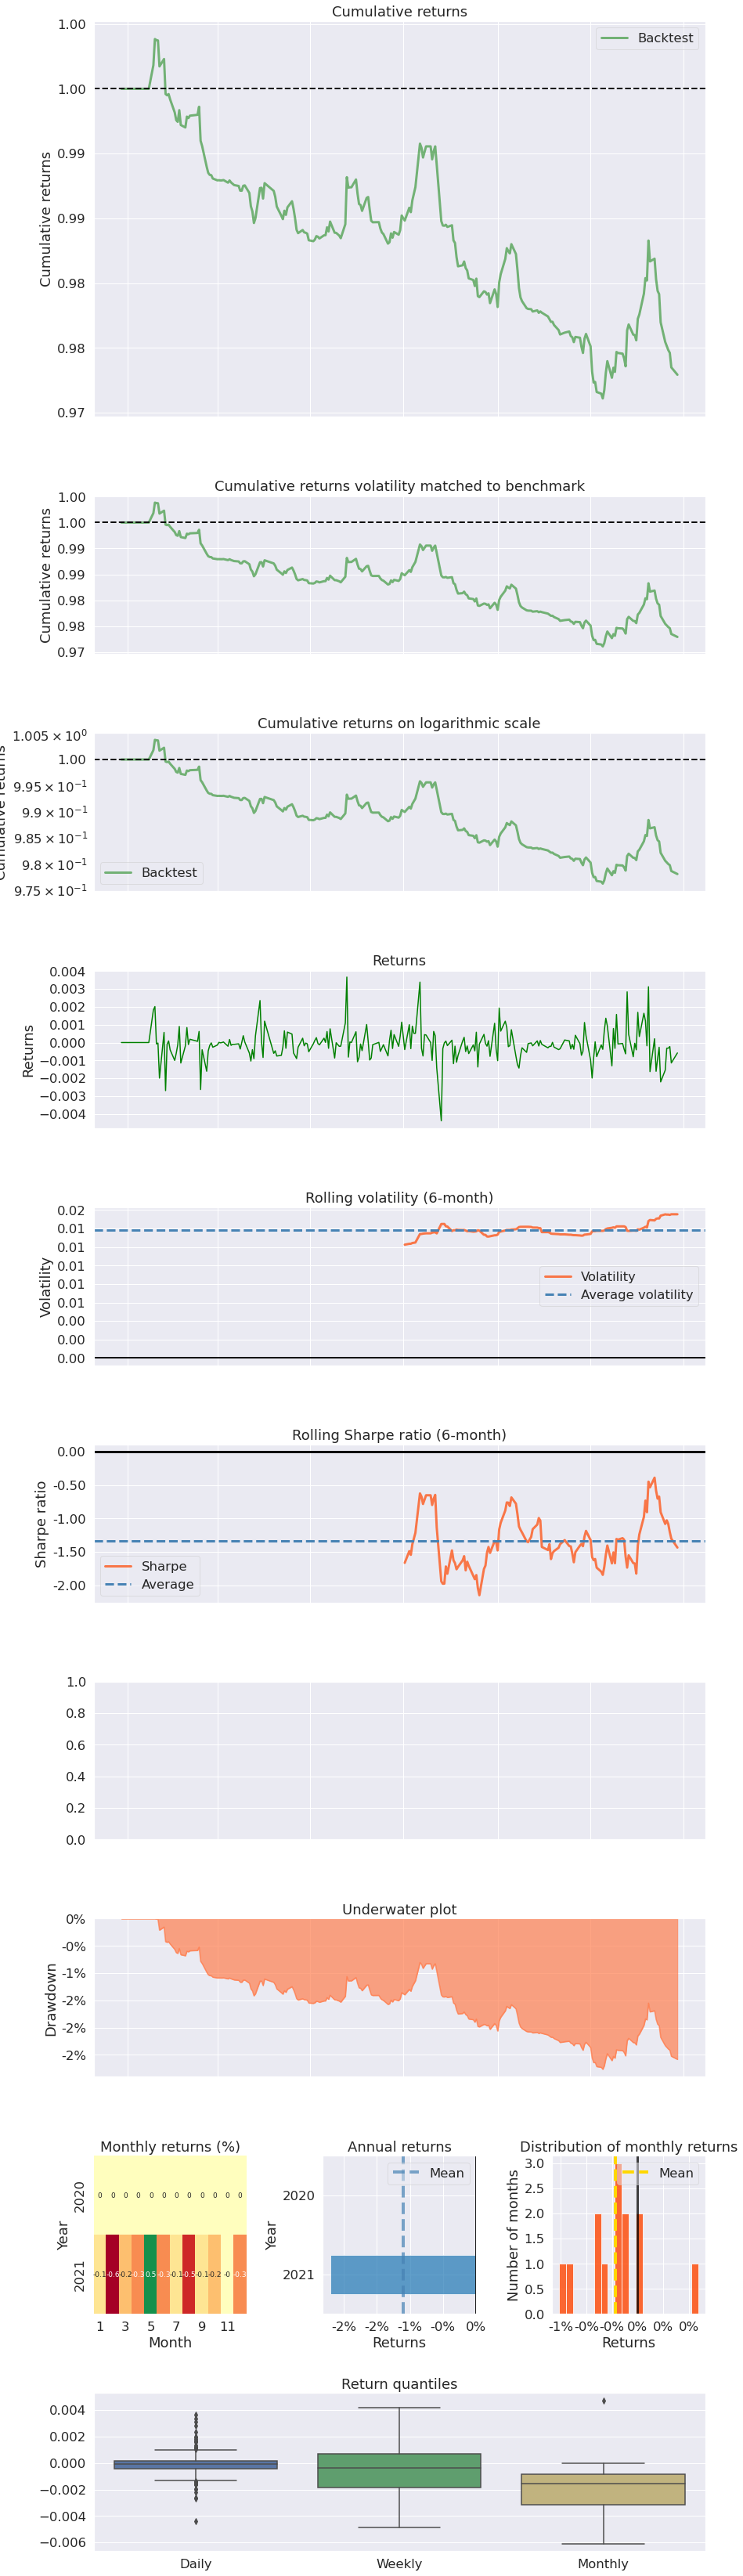

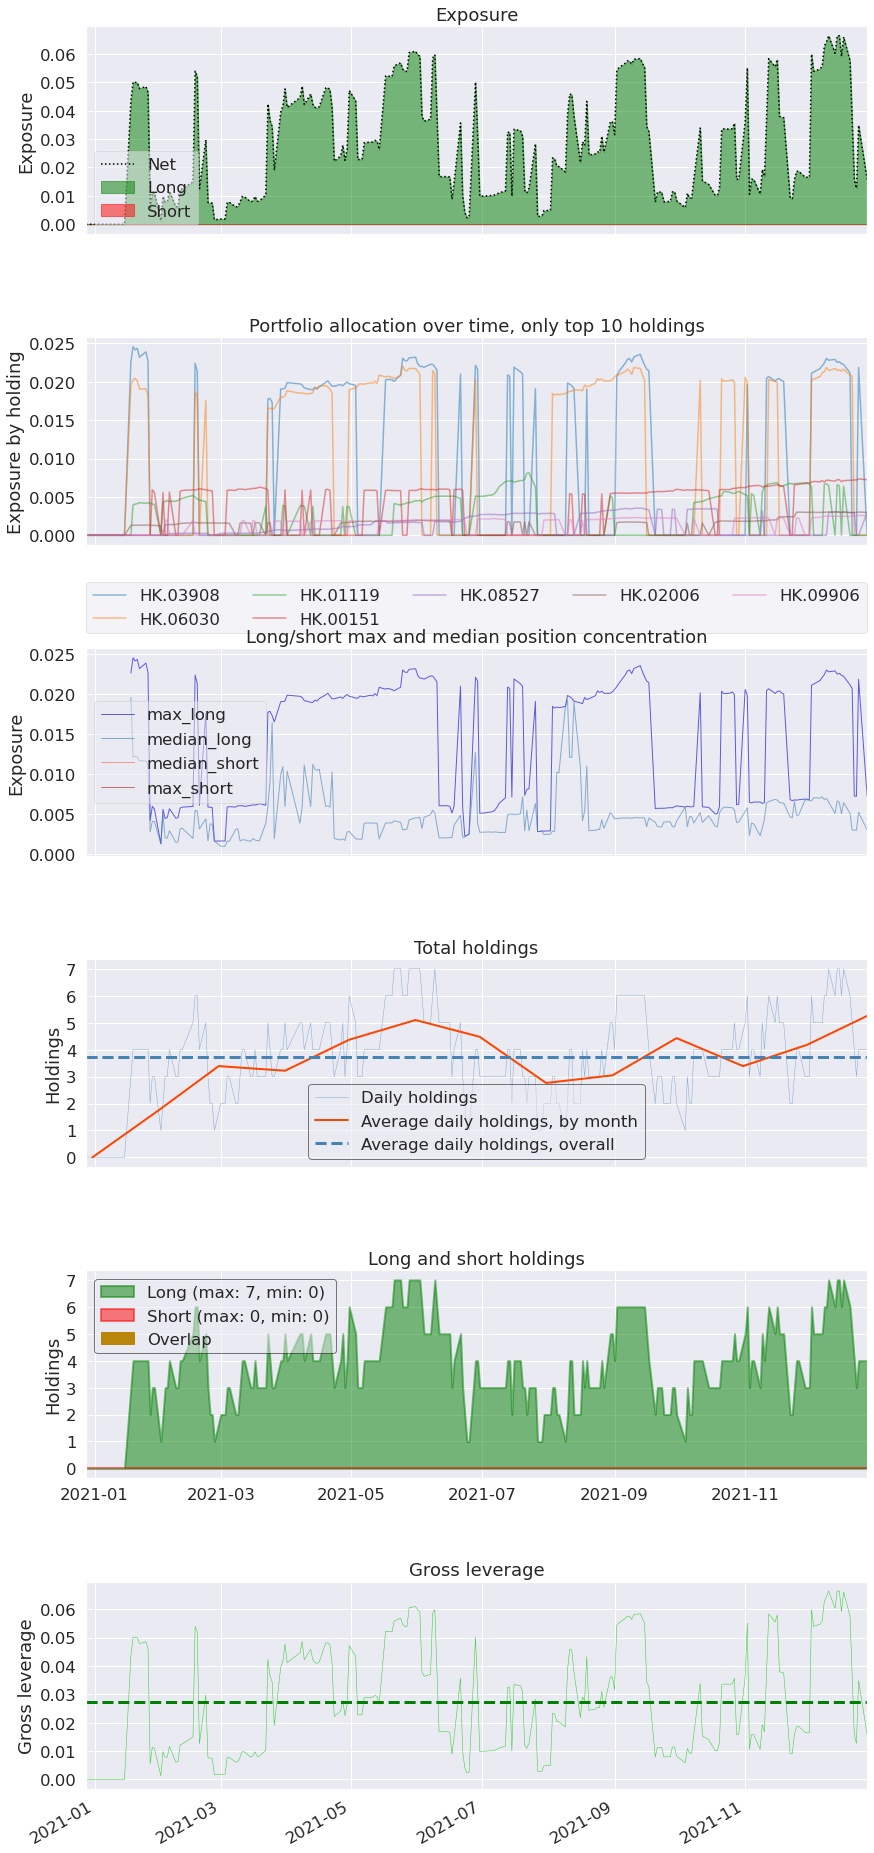

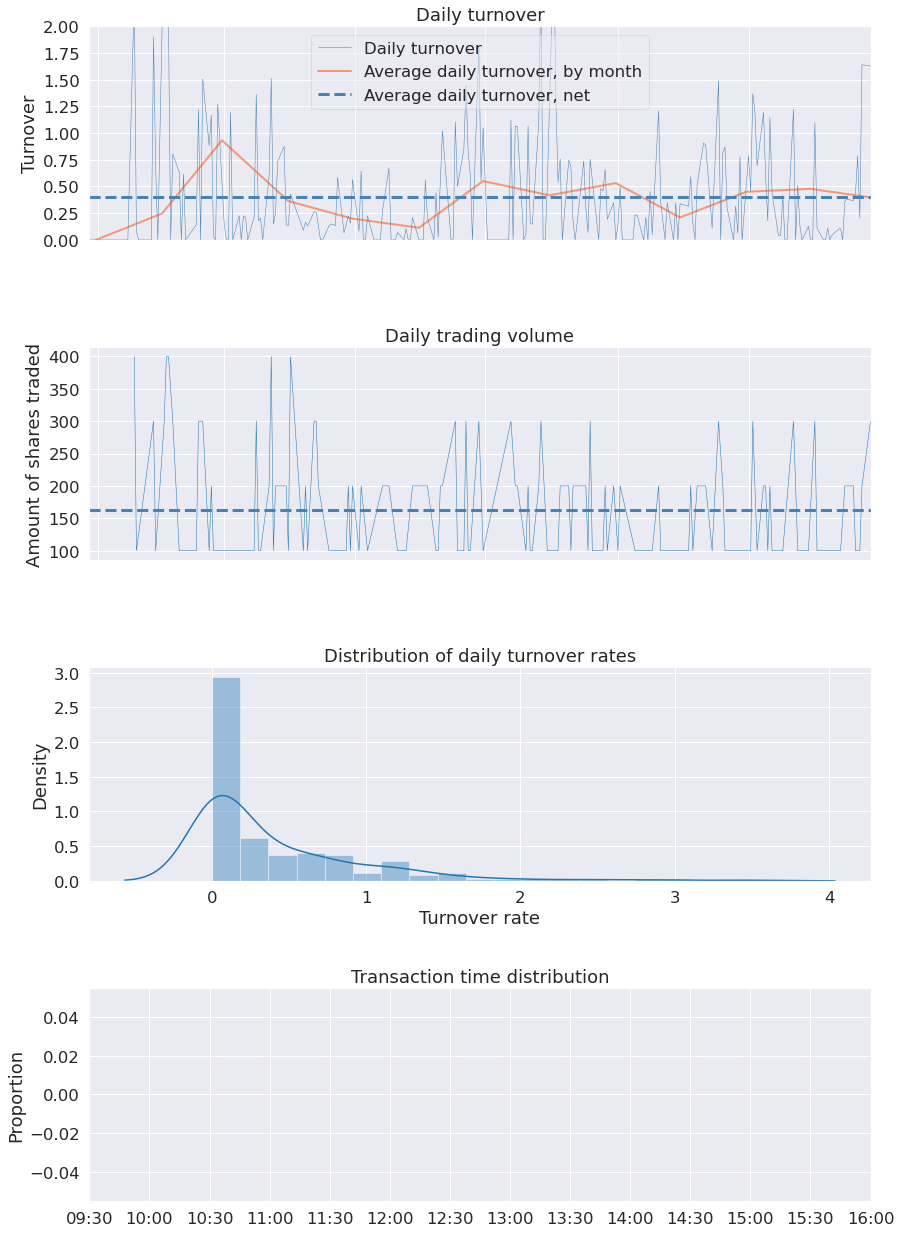

In [6]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from backtrader.analyzers import pyfolio
from futu import *
# from teststrat import TestStrategy
# from MarkMinerviniModel import *
# from FutuCommInfo import Futu_CommInfo
from random import sample

import argparse
# import PlateSelectionModel
import backtrader as bt
import backtrader.feeds as btfeeds
import datetime
import pandas as pd

############################ 全局变量设置 ############################
FUTUOPEND_ADDRESS = '127.0.0.1'  # FutuOpenD 监听地址
FUTUOPEND_PORT = 11111  # FutuOpenD 监听端口

TRADING_ENVIRONMENT = TrdEnv.SIMULATE  # 交易环境：真实 / 模拟
TRADING_PWD = '914138'  # 交易密码，用于解锁交易
TRADING_PERIOD = KLType.K_1M  # 信号 K 线周期
# TRADING_PERIOD = KLType.K_DAY
TRADING_SECURITY = 'HK.00700'  # 交易标的
FAST_MOVING_AVERAGE = 5  # 均线快线的周期
SLOW_MOVING_AVERAGE = 10  # 均线慢线的周期
SUBSCRIBE_NUM_THRESHOLD = 20
quote_context = OpenQuoteContext(
    host=FUTUOPEND_ADDRESS, port=FUTUOPEND_PORT)  # 行情对象
trade_context = OpenHKTradeContext(host=FUTUOPEND_ADDRESS, port=FUTUOPEND_PORT,
                                   security_firm=SecurityFirm.FUTUSECURITIES)  # 交易对象，根据交易标的修改交易对象类型

def get_acc_holdings():
    ret, data = trade_context.position_list_query(trd_env=TRADING_ENVIRONMENT)
    if ret != RET_OK:
        print('获取持仓数据失败:', data)
        return None
    else:
        if data.shape[0] > 0:
            holding_position = data['qty'][0]
        codes = data.code.tolist()
        quantity_list = data['qty'].tolist()
    return codes, quantity_list



def get_code_list():
    # get holding first
    valid_codes = []
    holding_codes, quantity_list = get_acc_holdings()
    valid_codes.extend(list(holding_codes))
    if len(valid_codes) >= SUBSCRIBE_NUM_THRESHOLD:
        return valid_codes
    stock_df = getStocks(quote_context)
    codes = stock_df['code'].tolist()
    print("holding codes = {}".format(holding_codes))
    print("candidate codes = {}".format(codes))
    valid_codes_2 = []
    end_time = datetime.datetime.now().strftime('%Y-%m-%d')
    for code in codes:
        try:
            # ret, data = quote_context.get_cur_kline(code, num=MMMODEL_PERIOD, ktype=SubType.K_DAY, autype=AuType.NONE)
#             print("try to get code = {} k lines, end_time = {}".format(code, end_time))
            ret, data, page_req_key = quote_context.request_history_kline(
                code, start=None, end=end_time, max_count=1000, ktype=SubType.K_DAY, autype=AuType.NONE)
            time.sleep(1)
            if ret != RET_OK:
                print(data)
                raise Exception("get code list k line failed")
            if data.empty:
                continue
            rule_result = checkMMRules(
                data['close'].iloc[-1], data, DEFAULT_MA_ONE_PERIOD, DEFAULT_MA_TWO_PERIOD, DEFAULT_MA_THREE_PERIOD)
            if rule_result['cond']:
                valid_codes_2.append(code)
        except Exception as ex:
            print(ex)
            continue
    # TODO it is only a temp solution to sample n stocks for reducing api access times
    if len(valid_codes_2) > SUBSCRIBE_NUM_THRESHOLD - len(valid_codes):
        rest_num = SUBSCRIBE_NUM_THRESHOLD - len(valid_codes)
        valid_codes.extend(sample(valid_codes_2, rest_num))
    else:
        valid_codes.extend(valid_codes_2)
    return valid_codes


code_list = get_code_list()
print('code list = {}'.format(code_list))


def generateDataFeed(code):
    global min_date
    end_time = datetime.datetime.now().strftime('%Y-%m-%d')
    ret, data, page_req_key = quote_context.request_history_kline(
        code, start=None, end=end_time, max_count=1000, ktype=SubType.K_DAY, autype=AuType.NONE)
    if ret != RET_OK:
        print(data)
        raise Exception("request history kline failed, code = {}".format(code))
    frame = data[["time_key", "open", "high", "low", "close", "volume"]]
    frame.rename(columns={"time_key": "Date"}, inplace=True)
    frame['Date'] = frame['Date'].apply(lambda time_key: time_key.split()[0])
    frame['Date'] = pd.to_datetime(frame['Date'])
    frame.set_index("Date", inplace=True)
    # print(frame)
    return frame

def runstrat():
    # args = parse_args()

    # Create a cerebro entity
    cerebro = bt.Cerebro(stdstats=False)

    # Add a strategy
    cerebro.addstrategy(TestStrategy)


    for code in code_list:
        print('----------------------------')
        print('try to generate code = {}'.format(code))
        dataframe = generateDataFeed(code)
        data = bt.feeds.PandasData(dataname=dataframe)
        # Pass it to the backtrader datafeed and add it to the cerebro
        cerebro.adddata(data, name=code)
        print(dataframe)
        print('----------------------------')

    # Set the commission - 0.03% ... divide by 100 to remove the % FUTU Commision
    futu_comminfo = Futu_CommInfo(commission=0.0003)
    # cerebro.broker.setcommission(commission=0.0003)
    cerebro.broker.addcommissioninfo(futu_comminfo)
    cerebro.broker.setcash(100000.0)
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)
#     cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    cerebro.addanalyzer(MyPyFolio, _name='pyfolio')
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    # Run over everything
    results = cerebro.run()
    strat = results[0]
    pyfoliozer = strat.analyzers.getbyname('pyfolio')
    returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print("positions:")
    print(positions)
    print("returns:")
    print(returns)
    import pyfolio as pf
    pf.create_full_tear_sheet(
        returns,
        positions=positions,
        transactions=transactions,
#         live_start_date="2021-01-01",
        round_trips=True)
    # Plot the result
    # cerebro.plot(style='bar')


if __name__ == '__main__':
    pd.set_option('display.max_columns', None)  # or 1000
    pd.set_option('display.max_rows', None)  # or 1000
    pd.set_option('display.max_colwidth', -1)  # or 199
    runstrat()
